<a href="https://colab.research.google.com/github/saloni-git/human-activity-recognition-using-different-RNN-models/blob/main/HAR_using_RNN_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Firstly , we will download the dataset.


In [ ]:
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from scipy.signal import savgol_filter
from scipy import signal
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
# Create the LSTM model
from tensorflow import keras, convert_to_tensor, float32, make_ndarray
from tensorflow.compat.v1 import Session
from tensorflow.keras import layers, backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, MaxPool1D, TimeDistributed, RepeatVector, Conv2D
from keras.layers.merge import concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import random


In [ ]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

--2021-04-11 14:48:45--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60999314 (58M) [application/x-httpd-php]
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip 100%[===================>]  58.17M  33.9MB/s    in 1.7s    

2021-04-11 14:48:47 (33.9 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314/60999314]



In [ ]:
#unzip it
!unzip "UCI HAR Dataset.zip"

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: UCI HAR Dataset/README.txt  
  inflating: __MACOSX/UCI HAR Dataset/._README.txt  
   creating: UCI HAR Dataset/test/
   creating: UCI HAR Dataset/test/Inertial Signals/
  inflating: UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: __MACOSX/UCI HAR Dataset/test/
   creating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/
  inflating: __MACOSX/UCI HAR Dataset/test/Inertial Signals/._body_acc_x_test.txt  
  inflating: UCI HAR

In [ ]:
#moving it into our current working directory
!mv "UCI HAR Dataset" HARDataset/

In [ ]:
from numpy import std
from numpy import dstack
from pandas import read_csv

Here we will try to load a group of files, such as all of the body acceleration data files as a single group.


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load the total acc data
filenames = ['total_acc_x_train.txt', 'total_acc_y_train.txt', 'total_acc_z_train.txt']
total_acc = load_group(filenames, prefix='HARDataset/train/Inertial Signals/')
print(total_acc.shape)

(7352, 128, 3)


In [ ]:
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load all train
trainX, trainy = load_dataset('train', 'HARDataset/')
print(trainX.shape, trainy.shape)
input_shape=(trainX.shape[1:])
# load all test
testX, testy = load_dataset('test', 'HARDataset/')
print(testX.shape, testy.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [ ]:
testr = testy
trainr = trainy

In [ ]:
testr = testr-1

In [ ]:
from keras.utils import np_utils

In [ ]:
# zero-offset class values
testy = testy - 1
trainy = trainy - 1

In [ ]:
#one hot encoding
testy = np_utils.to_categorical(testy)
testy.shape

(2947, 6)

In [ ]:
#one hot encoding
trainy = np_utils.to_categorical(trainy)
trainy.shape

(7352, 6)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense,Flatten

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [ ]:
import numpy as np


# **RNN model**


In [ ]:
from keras.layers import SimpleRNN
import tensorflow as tf

In [ ]:
#building a RNN 
#model creation
modelrnn = Sequential()
modelrnn.add(SimpleRNN(units = 128,input_shape=(128,9)))
modelrnn.add(Dense(units = 64, activation='relu'))
modelrnn.add(Dense(units = 6 , activation='sigmoid'))

In [ ]:
modelrnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               17664     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 390       
Total params: 26,310
Trainable params: 26,310
Non-trainable params: 0
_________________________________________________________________


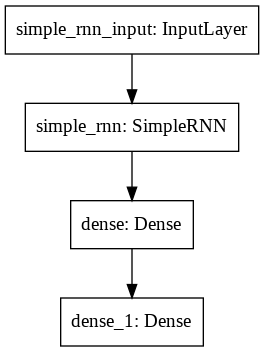

In [ ]:
tf.keras.utils.plot_model(modelrnn)

In [ ]:
#compile model
modelrnn.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#fitting model
history=modelrnn.fit(trainX,trainy,epochs=20,validation_data=(testX,testy))

Epoch 1/20
230/230 [==============================] - 8s 36ms/step - loss: 0.6204 - accuracy: 0.7325 - val_loss: 0.7876 - val_accuracy: 0.6742
Epoch 2/20
230/230 [==============================] - 8s 36ms/step - loss: 0.6112 - accuracy: 0.7437 - val_loss: 0.7033 - val_accuracy: 0.7078
Epoch 3/20
230/230 [==============================] - 8s 37ms/step - loss: 0.5797 - accuracy: 0.7490 - val_loss: 0.7588 - val_accuracy: 0.7075
Epoch 4/20
230/230 [==============================] - 8s 37ms/step - loss: 0.7720 - accuracy: 0.6763 - val_loss: 0.8323 - val_accuracy: 0.6478
Epoch 5/20
230/230 [==============================] - 8s 37ms/step - loss: 0.6433 - accuracy: 0.7350 - val_loss: 0.7788 - val_accuracy: 0.6820
Epoch 6/20
230/230 [==============================] - 8s 37ms/step - loss: 0.6011 - accuracy: 0.7433 - val_loss: 0.6934 - val_accuracy: 0.7129
Epoch 7/20
230/230 [==============================] - 9s 37ms/step - loss: 0.5725 - accuracy: 0.7575 - val_loss: 0.7295 - val_accuracy: 0.7472

In [ ]:
modelrnn.evaluate(testX, testy)

93/93 [==============================] - 1s 11ms/step - loss: 0.7131 - accuracy: 0.6966


[0.7131154537200928, 0.69664067029953]

In [ ]:
r_pred = modelrnn.predict_classes(testX)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Confusion Matrix

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f354de4fb90>)

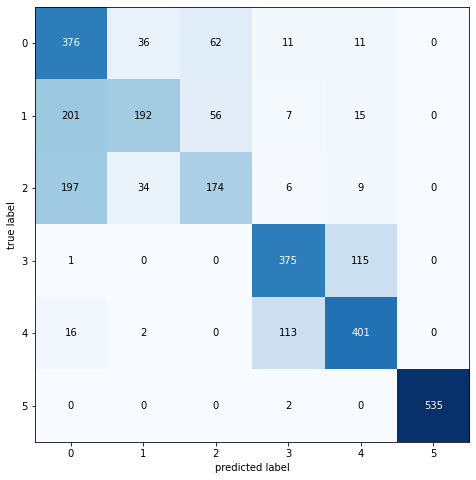

In [ ]:
mat = confusion_matrix(testr , r_pred)

plot_confusion_matrix(conf_mat = mat, show_normed=False , figsize=(10,8))


# Plotting Curves for Accuracy and Loss

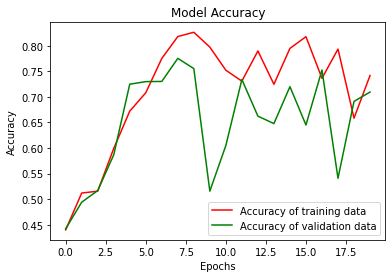

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'],'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'],'g', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

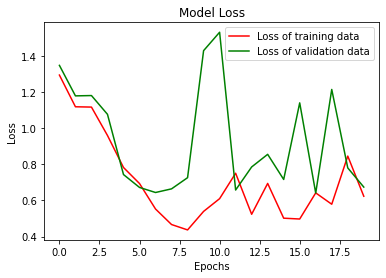

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'],'r', label='Loss of training data')
plt.plot(history.history['val_loss'],'g', label='Loss of validation data')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
y_pred = modelrnn.predict(testX)
y_pred_classes = [np.argmax(element) for element in y_pred]
print('\nClassification Report\n')
print(classification_report(testr, y_pred_classes, target_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]))
#here we needed testr not testy


Classification Report

                    precision    recall  f1-score   support

           WALKING       0.53      0.44      0.48       496
  WALKING_UPSTAIRS       0.54      0.54      0.54       471
WALKING_DOWNSTAIRS       0.60      0.69      0.64       420
           SITTING       0.73      0.86      0.79       491
          STANDING       0.82      0.74      0.78       532
            LAYING       0.99      0.95      0.97       537

          accuracy                           0.71      2947
         macro avg       0.70      0.70      0.70      2947
      weighted avg       0.71      0.71      0.71      2947



## We can see RNN model gives an accuracy of 71%

# **LSTM model**

In [ ]:
from keras.layers import LSTM

In [ ]:
#building a LSTM
#model creation
modellstm = Sequential()
modellstm.add(LSTM(units = 128,input_shape=(trainX.shape[1:]),return_sequences=True))
modellstm.add(LSTM(units = 64))
modellstm.add(Dense(units = 64, activation='relu'))
modellstm.add(Dense(units = 6 , activation='sigmoid'))

In [ ]:
modellstm.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modellstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 128)          70656     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 124,614
Trainable params: 0
Non-trainable params: 124,614
_________________________________________________________________


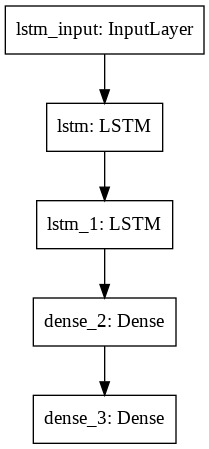

In [ ]:
tf.keras.utils.plot_model(modellstm)

In [ ]:
historyy=modellstm.fit(trainX,trainy,epochs=20,validation_data=(testX,testy))

Epoch 1/20
230/230 [==============================] - 53s 215ms/step - loss: 1.2175 - accuracy: 0.4659 - val_loss: 0.8654 - val_accuracy: 0.6359
Epoch 2/20
230/230 [==============================] - 48s 209ms/step - loss: 0.5957 - accuracy: 0.7447 - val_loss: 0.9958 - val_accuracy: 0.6179
Epoch 3/20
230/230 [==============================] - 48s 210ms/step - loss: 0.6997 - accuracy: 0.7011 - val_loss: 0.4277 - val_accuracy: 0.8405
Epoch 4/20
230/230 [==============================] - 48s 210ms/step - loss: 0.3199 - accuracy: 0.8835 - val_loss: 0.3385 - val_accuracy: 0.8843
Epoch 5/20
230/230 [==============================] - 48s 211ms/step - loss: 0.1826 - accuracy: 0.9318 - val_loss: 0.3362 - val_accuracy: 0.8931
Epoch 6/20
230/230 [==============================] - 49s 214ms/step - loss: 0.1499 - accuracy: 0.9406 - val_loss: 0.3284 - val_accuracy: 0.8968
Epoch 7/20
230/230 [==============================] - 49s 214ms/step - loss: 0.1366 - accuracy: 0.9459 - val_loss: 0.3401 - val_ac

In [ ]:
modellstm.evaluate(testX, testy)

93/93 [==============================] - 6s 59ms/step - loss: 0.3017 - accuracy: 0.9179


[0.301735520362854, 0.9178826212882996]

In [ ]:
r_pred = modellstm.predict_classes(testX)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Confusion Matrix

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f652758f0d0>)

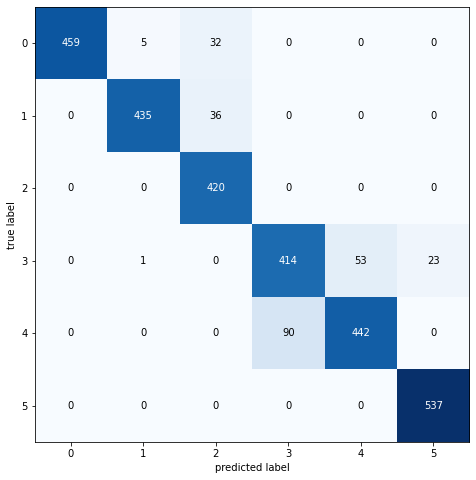

In [ ]:
mat = confusion_matrix(testr , r_pred)
plot_confusion_matrix(conf_mat = mat, show_normed=False , figsize=(10,8))


# Plotting Curves for Accuracy and Loss

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(historyy.history['accuracy'],'r', label='Accuracy of training data')
plt.plot(historyy.history['val_accuracy1'],'g', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

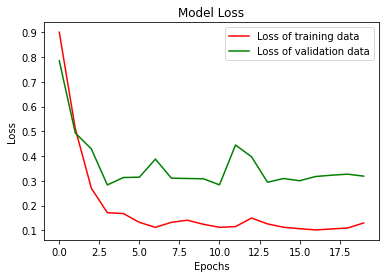

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(historyy.history['loss'],'r', label='Loss of training data')
plt.plot(historyy.history['val_loss'],'g', label='Loss of validation data')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
y_pred = modellstm.predict(testX)
y_pred_classes = [np.argmax(element) for element in y_pred]
print('\nClassification Report\n')
print(classification_report(testr, y_pred_classes, target_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]))
#here we needed testr not testy


Classification Report

                    precision    recall  f1-score   support

           WALKING       1.00      0.93      0.96       496
  WALKING_UPSTAIRS       0.99      0.92      0.95       471
WALKING_DOWNSTAIRS       0.86      1.00      0.93       420
           SITTING       0.82      0.84      0.83       491
          STANDING       0.89      0.83      0.86       532
            LAYING       0.96      1.00      0.98       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947



# We can see LSTM model gives an accuracy of 92%
Therefore we can say LSTM works well on time-series data.

# **GRU Model**

In [ ]:
from keras.layers import GRU

In [ ]:
#building a GRU
#model creation
modelgru = Sequential()
modelgru.add(GRU(units = 128,input_shape=(trainX.shape[1:]),return_sequences=True))
modelgru.add(GRU(units = 64))
modelgru.add(Dense(units = 64, activation='relu'))
modelgru.add(Dense(units = 6 , activation='sigmoid'))

In [ ]:
modelgru.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
modelgru.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 128, 128)          53376     
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 95,174
Trainable params: 95,174
Non-trainable params: 0
_________________________________________________________________


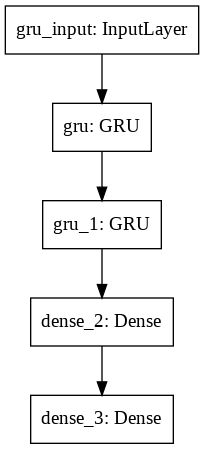

In [ ]:
tf.keras.utils.plot_model(modelgru)

In [ ]:
history=modelgru.fit(trainX,trainy,epochs=20,validation_data=(testX,testy))

Epoch 1/20
230/230 [==============================] - 43s 186ms/step - loss: 0.0674 - accuracy: 0.9736 - val_loss: 0.3367 - val_accuracy: 0.9155
Epoch 2/20
230/230 [==============================] - 43s 186ms/step - loss: 0.0685 - accuracy: 0.9740 - val_loss: 0.3204 - val_accuracy: 0.9209
Epoch 3/20
230/230 [==============================] - 43s 186ms/step - loss: 0.0670 - accuracy: 0.9732 - val_loss: 0.3472 - val_accuracy: 0.9131
Epoch 4/20
230/230 [==============================] - 43s 188ms/step - loss: 0.0789 - accuracy: 0.9699 - val_loss: 0.3065 - val_accuracy: 0.9138
Epoch 5/20
230/230 [==============================] - 43s 186ms/step - loss: 0.0696 - accuracy: 0.9729 - val_loss: 0.2355 - val_accuracy: 0.9253
Epoch 6/20
230/230 [==============================] - 43s 185ms/step - loss: 0.0618 - accuracy: 0.9763 - val_loss: 0.2850 - val_accuracy: 0.9270
Epoch 7/20
230/230 [==============================] - 42s 185ms/step - loss: 0.0566 - accuracy: 0.9785 - val_loss: 0.2687 - val_ac

In [ ]:
modelgru.evaluate(testX, testy)

93/93 [==============================] - 4s 42ms/step - loss: 0.3252 - accuracy: 0.9030


[0.32515692710876465, 0.9029521346092224]

In [ ]:
r_pred = modelgru.predict_classes(testX)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


# Confusion Matrix

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f68d5e09590>)

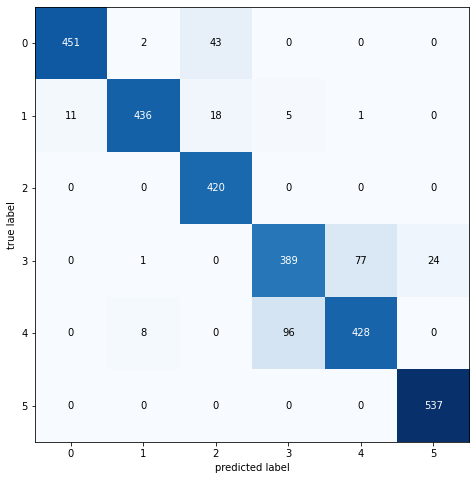

In [ ]:
mat = confusion_matrix(testr , r_pred)
plot_confusion_matrix(conf_mat = mat, show_normed=False , figsize=(10,8))

# Plotting Curves for Accuracy and Loss

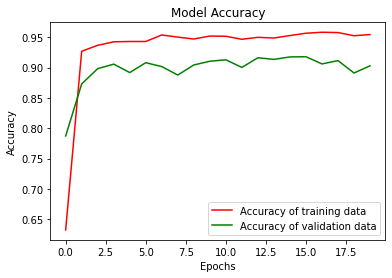

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'],'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'],'g', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

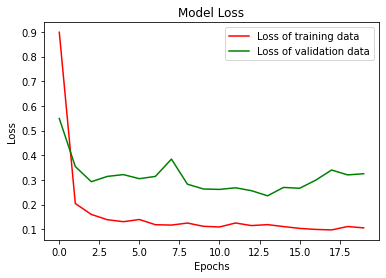

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'],'r', label='Loss of training data')
plt.plot(history.history['val_loss'],'g', label='Loss of validation data')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Classification Report

In [ ]:
from sklearn.metrics import classification_report
y_pred = modelgru.predict(testX)
y_pred_classes = [np.argmax(element) for element in y_pred]
print('\nClassification Report\n')
print(classification_report(testr, y_pred_classes, target_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]))
#here we needed testr not testy


Classification Report

                    precision    recall  f1-score   support

           WALKING       0.98      0.91      0.94       496
  WALKING_UPSTAIRS       0.98      0.93      0.95       471
WALKING_DOWNSTAIRS       0.87      1.00      0.93       420
           SITTING       0.79      0.79      0.79       491
          STANDING       0.85      0.80      0.82       532
            LAYING       0.96      1.00      0.98       537

          accuracy                           0.90      2947
         macro avg       0.90      0.91      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



# GRU model gives an accuracy of 90%

Combining all 3 models 

In [ ]:
modelrnn.trainable = False
modelgru.trainable = False
modellstm.trainable = False

In [ ]:
input = Input(shape=input_shape)
x1 = modelrnn(input)
x2 = modelgru(input)
x3 = modellstm(input)
x = concatenate([x1,x2,x3])
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
n_outputs=6
output = Dense(n_outputs, activation='relu')(x) 

In [ ]:
model = Model(input, output)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 9)]     0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 6)            26310       input_4[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 6)            95174       input_4[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 6)            124614      input_4[0][0]                    
____________________________________________________________________________________________

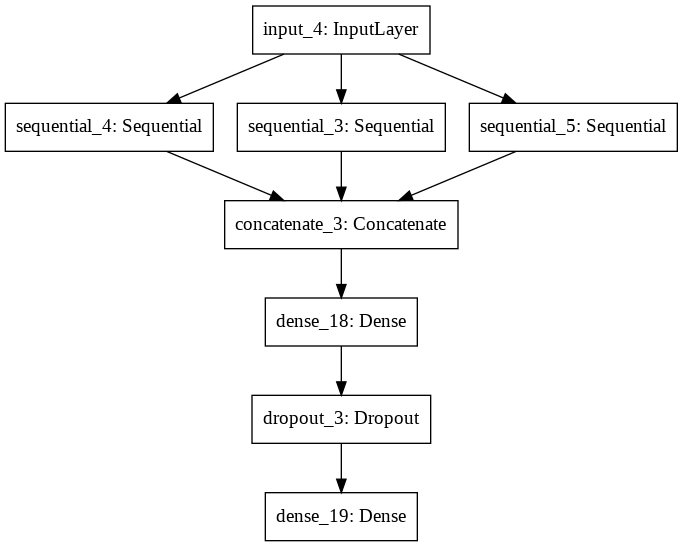

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
historyy=model.fit(trainX,trainy,epochs=50,validation_data=(testX,testy))

Epoch 1/50
230/230 [==============================] - 26s 113ms/step - loss: 0.0106 - accuracy: 0.9591 - val_loss: 0.0219 - val_accuracy: 0.9138
Epoch 2/50
230/230 [==============================] - 26s 112ms/step - loss: 0.0107 - accuracy: 0.9585 - val_loss: 0.0223 - val_accuracy: 0.9169
Epoch 3/50
230/230 [==============================] - 26s 112ms/step - loss: 0.0108 - accuracy: 0.9584 - val_loss: 0.0217 - val_accuracy: 0.9165
Epoch 4/50
230/230 [==============================] - 26s 113ms/step - loss: 0.0106 - accuracy: 0.9576 - val_loss: 0.0225 - val_accuracy: 0.9148
Epoch 5/50
230/230 [==============================] - 26s 114ms/step - loss: 0.0106 - accuracy: 0.9585 - val_loss: 0.0223 - val_accuracy: 0.9152
Epoch 6/50
230/230 [==============================] - 26s 114ms/step - loss: 0.0105 - accuracy: 0.9599 - val_loss: 0.0226 - val_accuracy: 0.9199
Epoch 7/50
230/230 [==============================] - 26s 114ms/step - loss: 0.0107 - accuracy: 0.9584 - val_loss: 0.0218 - val_ac


Figure 28​





In [ ]:

model.evaluate(testX, testy)

93/93 [==============================] - 7s 80ms/step - loss: 0.0233 - accuracy: 0.9162


[0.02329675294458866, 0.9161859750747681]

In [ ]:
import numpy as np

In [ ]:
np.argmax(model.predict(testX), axis=-1)

array([4, 4, 4, ..., 1, 1, 1])

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f3551ab4a90>)

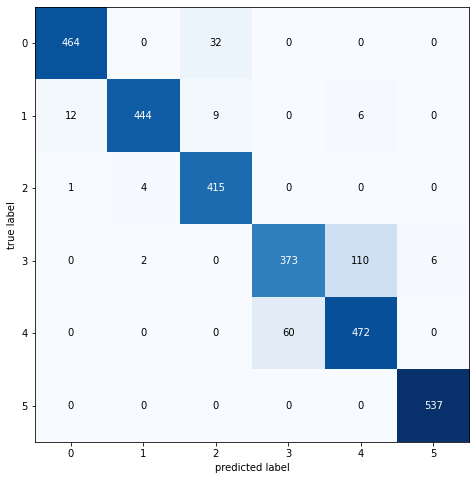

In [ ]:
mat = confusion_matrix(testr , r_pred)
plot_confusion_matrix(conf_mat = mat , figsize=(10,8))

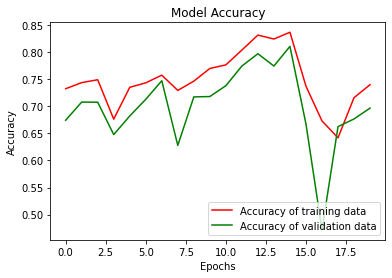

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'],'r', label='Accuracy of training data')
plt.plot(history.history['val_accuracy'],'g', label='Accuracy of validation data')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

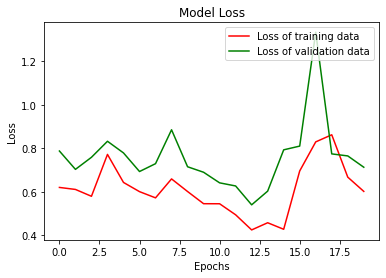

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'],'r', label='Loss of training data')
plt.plot(history.history['val_loss'],'g', label='Loss of validation data')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
y_pred = model.predict(testX)
y_pred_classes = [np.argmax(element) for element in y_pred]
print('\nClassification Report\n')
print(classification_report(testr, y_pred_classes, target_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]))



Classification Report

                    precision    recall  f1-score   support

           WALKING       0.96      0.93      0.95       496
  WALKING_UPSTAIRS       0.98      0.95      0.96       471
WALKING_DOWNSTAIRS       0.91      0.99      0.95       420
           SITTING       0.84      0.78      0.81       491
          STANDING       0.81      0.85      0.83       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.92      2947
         macro avg       0.92      0.92      0.92      2947
      weighted avg       0.92      0.92      0.92      2947

